In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder

# Load your dataset and split it into features (X) and target (y)
stroke_df = pd.read_csv("healthcare-dataset-stroke-data.csv")
stroke_df

stroke_df.drop(columns=['bmi'], inplace=True)

class MultiColumnLabelEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.encoders = {}
        for column in X.columns:
            le = LabelEncoder()
            le.fit(X[column].astype(str))
            self.encoders[column] = le
        return self
    
    def transform(self, X, y=None):
        X_copy = X.copy()
        for column, encoder in self.encoders.items():
            X_copy[column] = encoder.transform(X_copy[column].astype(str))
        return X_copy
    
encoder = MultiColumnLabelEncoder()
stroke_encoded = encoder.fit_transform(stroke_df)
stroke_encoded


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,smoking_status,stroke
0,5053,1,85,0,1,1,2,1,1618,1,1
1,3218,0,79,0,0,1,3,0,1356,2,1
2,1593,1,100,0,1,1,2,0,251,2,1
3,3907,0,65,0,0,1,2,1,1153,3,1
4,530,0,98,1,0,1,3,0,1162,2,1
...,...,...,...,...,...,...,...,...,...,...,...
5105,652,0,100,1,0,1,2,1,3107,2,0
5106,2641,0,101,0,0,1,3,1,798,2,0
5107,745,0,50,0,0,1,3,0,3061,2,0
5108,2105,1,68,0,0,1,2,0,1131,1,0


In [14]:
# Isolating the average glucose column
scaler = StandardScaler()
glucose_levels = stroke_encoded[['avg_glucose_level']]

# Fitted and transformed data
scaled_glucose_levels = scaler.fit_transform(glucose_levels)
stroke_encoded['avg_glucose_level'] = scaled_glucose_levels
stroke_encoded

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,smoking_status,stroke
0,5053,1,85,0,1,1,2,1,-0.406599,1,1
1,3218,0,79,0,0,1,3,0,-0.632663,2,1
2,1593,1,100,0,1,1,2,0,-1.586101,2,1
3,3907,0,65,0,0,1,2,1,-0.807819,3,1
4,530,0,98,1,0,1,3,0,-0.800054,2,1
...,...,...,...,...,...,...,...,...,...,...,...
5105,652,0,100,1,0,1,2,1,0.878169,2,0
5106,2641,0,101,0,0,1,3,1,-1.114128,2,0
5107,745,0,50,0,0,1,3,0,0.838479,2,0
5108,2105,1,68,0,0,1,2,0,-0.826802,1,0


In [21]:
from sklearn.tree import DecisionTreeClassifier

# Feature selection
X = stroke_encoded[['hypertension', 'heart_disease', 'avg_glucose_level']]
y = stroke_encoded['stroke']

# This step we are splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# This following step is fitting the KNN model with the training data
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)

dt_model = DecisionTreeClassifier()
dt_model.fit(X_train_scaled, y_train)

input_df = pd.DataFrame(stroke_encoded)

input_df = input_df[['hypertension', 'heart_disease', 'avg_glucose_level']]

# An additional level of scaling for this dataset since we're only working with three features
input_scaled = scaler.transform(input_df)

# Predictions using the trained Decision Tree Classifier model
probabilities = dt_model.predict_proba(input_scaled)[:, 1]  

# We are now adding the prediction of stroke probability to these three selected features
input_df['stroke_probability'] = probabilities

print(input_df)


      hypertension  heart_disease  avg_glucose_level  stroke_probability
0                0              1          -0.406599                 1.0
1                0              0          -0.632663                 1.0
2                0              1          -1.586101                 1.0
3                0              0          -0.807819                 1.0
4                1              0          -0.800054                 1.0
...            ...            ...                ...                 ...
5105             1              0           0.878169                 0.0
5106             0              0          -1.114128                 0.0
5107             0              0           0.838479                 0.0
5108             0              0          -0.826802                 0.0
5109             0              0           0.959276                 0.0

[5110 rows x 4 columns]


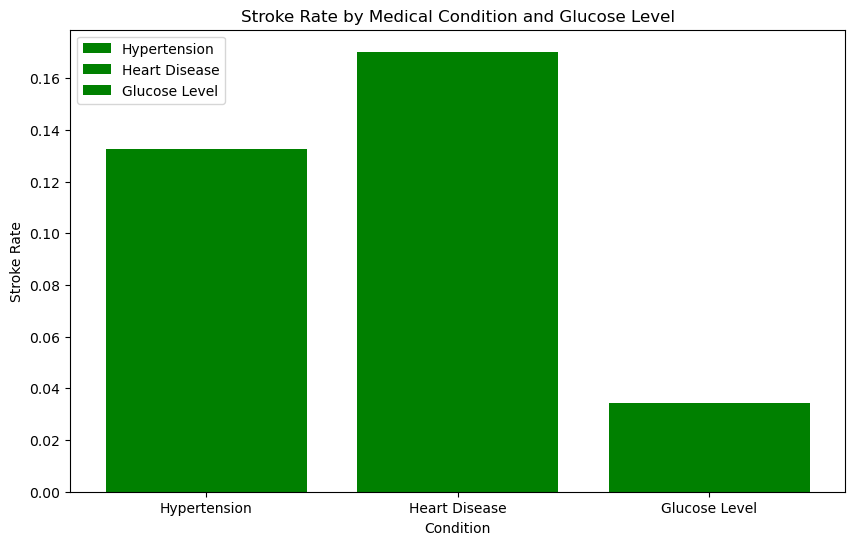

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'stroke_data' is your DataFrame
# and it includes a 'stroke' column with 1 indicating stroke and 0 for no stroke

# Create categories for average glucose level
glucose_categories = pd.cut(stroke_encoded['avg_glucose_level'], bins=[0, 100, 140, np.inf], labels=['Low', 'Medium', 'High'])
stroke_encoded['glucose_category'] = glucose_categories

# Calculating stroke rate for hypertension
hypertension_stroke_rate = stroke_encoded.groupby('hypertension')['stroke'].mean()

# Calculating stroke rate for heart disease
heart_disease_stroke_rate = stroke_encoded.groupby('heart_disease')['stroke'].mean()

# Calculating stroke rate for glucose levels
glucose_stroke_rate = stroke_encoded.groupby('glucose_category')['stroke'].mean()

# Here we're combining all the stroke 
stroke_rate_data = pd.DataFrame({
    'Hypertension': hypertension_stroke_rate,
    'Heart Disease': heart_disease_stroke_rate,
    'Glucose Level': glucose_stroke_rate
})

# Convert to a "tidy" format for easier plotting with seaborn or matplotlib
tidy_stroke_data = stroke_rate_data.melt(var_name='Condition', value_name='Stroke Rate')

# Now, we can plot this using matplotlib
plt.figure(figsize=(10, 6))
bar_chart = plt.bar(tidy_stroke_data['Condition'], tidy_stroke_data['Stroke Rate'], color=['green', 'green', 'green'])

plt.xlabel('Condition')
plt.ylabel('Stroke Rate')
plt.title('Stroke Rate by Medical Condition and Glucose Level')
plt.legend(bar_chart, ['Hypertension', 'Heart Disease', 'Glucose Level'])

plt.show()
